In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from sklearn.metrics import mean_absolute_error, r2_score, mean_absolute_percentage_error

In [2]:
data = pd.read_csv('../data/data.csv')

In [3]:
data.head()

,COUNTRY,CODE_TIME,TIME,YEAR,MONTH,MONTH_NAME,PRODUCT,VALUE,DISPLAY_ORDER,yearToDate,previousYearToDate,share
0,Australia,JAN2010,January 2010,2010,1,January,Hydro,990.728,1,16471.891,NaN,0.047771
1,Australia,JAN2010,January 2010,2010,1,January,Wind,409.469,2,4940.909,NaN,0.019744
2,Australia,JAN2010,January 2010,2010,1,January,Solar,49.216,3,908.238,NaN,0.002373
3,Australia,JAN2010,January 2010,2010,1,January,Geothermal,0.083,4,0.996,NaN,0.000004
4,Australia,JAN2010,January 2010,2010,1,January,Total combustible fuels,19289.730,7,214302.969,NaN,0.930108


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 181915 entries, 0 to 181914
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   COUNTRY             181915 non-null  object 
 1   CODE_TIME           181915 non-null  object 
 2   TIME                181915 non-null  object 
 3   YEAR                181915 non-null  int64  
 4   MONTH               181915 non-null  int64  
 5   MONTH_NAME          181915 non-null  object 
 6   PRODUCT             181915 non-null  object 
 7   VALUE               181915 non-null  float64
 8   DISPLAY_ORDER       181915 non-null  int64  
 9   yearToDate          181915 non-null  float64
 10  previousYearToDate  164810 non-null  float64
 11  share               181915 non-null  float64
dtypes: float64(4), int64(3), object(5)
memory usage: 16.7+ MB


In [5]:
data.isna().sum()

COUNTRY                   0
CODE_TIME                 0
TIME                      0
YEAR                      0
MONTH                     0
MONTH_NAME                0
PRODUCT                   0
VALUE                     0
DISPLAY_ORDER             0
yearToDate                0
previousYearToDate    17105
share                     0
dtype: int64

In [6]:
data.drop(columns=['DISPLAY_ORDER', 'previousYearToDate', 'CODE_TIME'], inplace=True)

In [7]:
def filter_products(df, product):
    if isinstance(product, str):
        return df[df["PRODUCT"] == product]
    
    elif isinstance(product, (list, tuple, set)):
        return df[df["PRODUCT"].isin(product)]
    
    else:
        raise TypeError("El parámetro 'product' debe ser un string o una lista/tupla/set.")

def filter_countries(df, country):
    if isinstance(country, str):
        return df[df["COUNTRY"] == country]
    
    elif isinstance(country, (list, tuple, set)):
        return df[df["COUNTRY"].isin(country)]
    
    else:
        raise TypeError("El parámetro 'country' debe ser un string o una lista/tupla/set.")

In [8]:
chile = filter_countries(data, "Chile")

In [9]:
chile["PRODUCT"].value_counts()

PRODUCT
Hydro                               156
Wind                                156
Total combustible fuels             156
Coal                                156
Oil                                 156
Natural gas                         156
Combustible renewables              156
Net electricity production          156
Electricity supplied                156
Final consumption                   156
Distribution losses                 156
Other renewables aggregated         156
Others                              156
Renewables                          156
Non-renewables                      156
Low carbon                          156
Fossil fuels                        156
Solar                               118
Not specified                       110
Electricity trade                    78
Geothermal                           70
Total imports                        69
Total exports                        58
Other renewables                     48
Nuclear                         

In [10]:
products = ["Non-renewables", "Renewables"]
renewables = ["Solar", "Wind", "Hydro", "Geothermal, Combustible renewables"]
non_renewables = ["Coal", "Natural gas", "Oil"]

detailed_products = ["Solar", "Wind", "Hydro", "Geothermal", "Coal", "Natural gas", "Oil", "Combustible renewables"]

chile_products = filter_products(chile, products)
chile_renewables = filter_products(chile, renewables)
chile_non_renewables = filter_products(chile, non_renewables)
chile_detailed = filter_products(chile, detailed_products)

In [11]:
def make_period_id(df):
    base_year = 2010
    df['periodo_id'] = (df['YEAR'] - base_year) * 12 + df['MONTH']
    return df


chile_products_id = make_period_id(chile_products)
chile_renewables_id = make_period_id(chile_renewables)
chile_non_renewables_id = make_period_id(chile_non_renewables)
chile_detailed_id = make_period_id(chile_detailed)
chile_full_id = make_period_id(chile)

C:\Users\Admin\AppData\Local\Temp\ipykernel_28244\2055583830.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['periodo_id'] = (df['YEAR'] - base_year) * 12 + df['MONTH']
C:\Users\Admin\AppData\Local\Temp\ipykernel_28244\2055583830.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['periodo_id'] = (df['YEAR'] - base_year) * 12 + df['MONTH']
C:\Users\Admin\AppData\Local\Temp\ipykernel_28244\2055583830.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

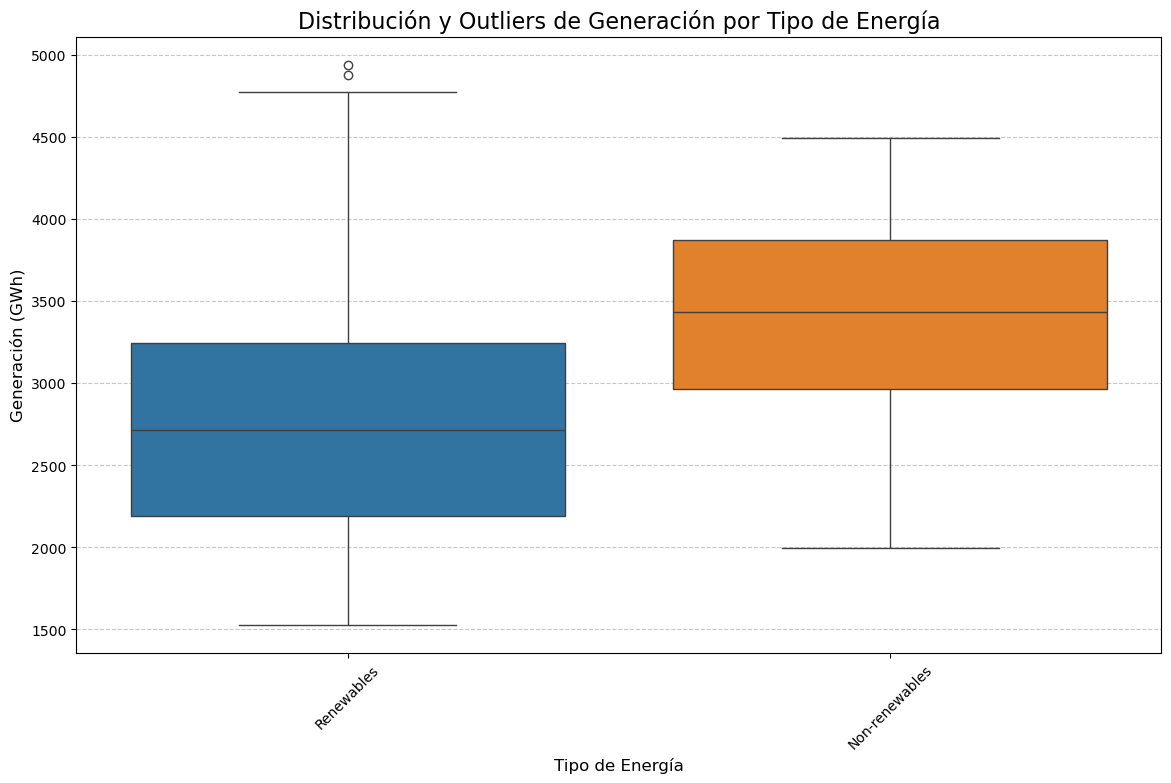

In [ ]:
# Configurar el tamaño de la figura para que sea legible
plt.figure(figsize=(14, 8))

# Crear el Boxplot
sns.boxplot(data=chile_products_id, x='PRODUCT', y='VALUE', hue='PRODUCT')

# Añadir títulos y etiquetas para dar contexto
plt.title('Distribución y Outliers de Generación por Tipo de Energía', fontsize=16)
plt.xlabel('Tipo de Energía', fontsize=12)
plt.ylabel('Generación (GWh)', fontsize=12)

# Rotar los nombres de los productos en el eje X para evitar solapamiento
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.grid(True, axis='y', linestyle='--', alpha=0.7) # Añade una rejilla suave horizontal
plt.show()

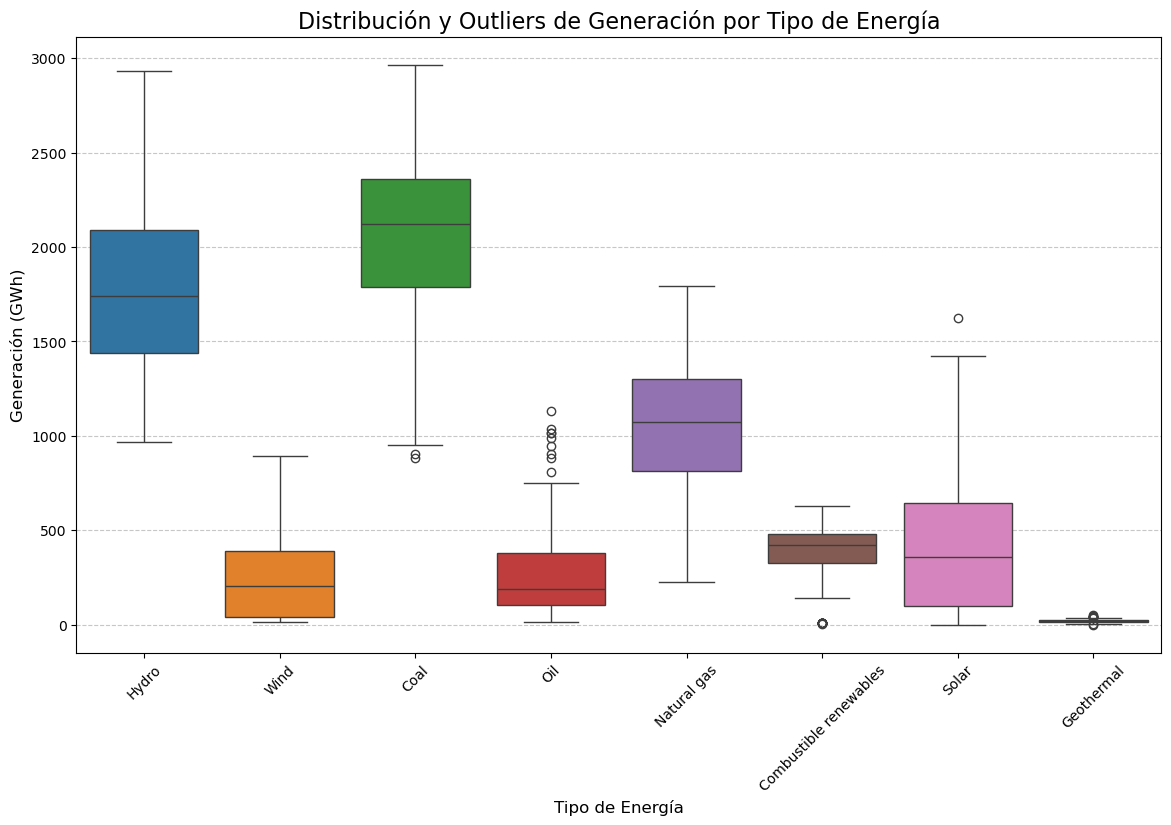

In [ ]:
# Configurar el tamaño de la figura para que sea legible
plt.figure(figsize=(14, 8))

# Crear el Boxplot
sns.boxplot(data=chile_detailed_id, x='PRODUCT', y='VALUE', hue='PRODUCT')

# Añadir títulos y etiquetas para dar contexto
plt.title('Distribución y Outliers de Generación por Tipo de Energía', fontsize=16)
plt.xlabel('Tipo de Energía', fontsize=12)
plt.ylabel('Generación (GWh)', fontsize=12)

# Rotar los nombres de los productos en el eje X para evitar solapamiento
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.grid(True, axis='y', linestyle='--', alpha=0.7) # Añade una rejilla suave horizontal
plt.show()

<Axes: xlabel='periodo_id', ylabel='VALUE'>

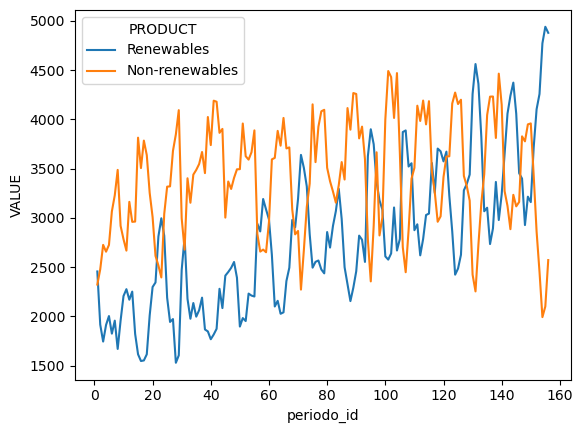

In [14]:
sns.lineplot(data=chile_products_id, x="periodo_id", y="VALUE", hue="PRODUCT")

<Axes: xlabel='periodo_id', ylabel='VALUE'>

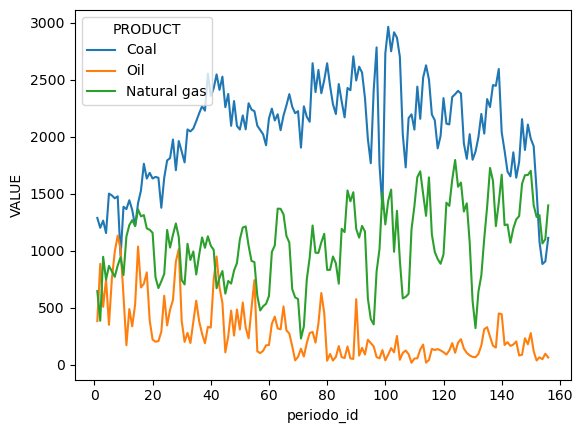

In [15]:
sns.lineplot(data=chile_non_renewables_id, x="periodo_id", y="VALUE", hue="PRODUCT")

<Axes: xlabel='periodo_id', ylabel='VALUE'>

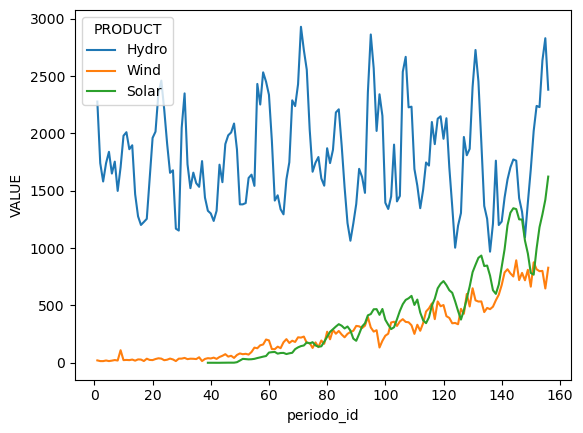

In [16]:
sns.lineplot(data=chile_renewables_id, x="periodo_id", y="VALUE", hue="PRODUCT")

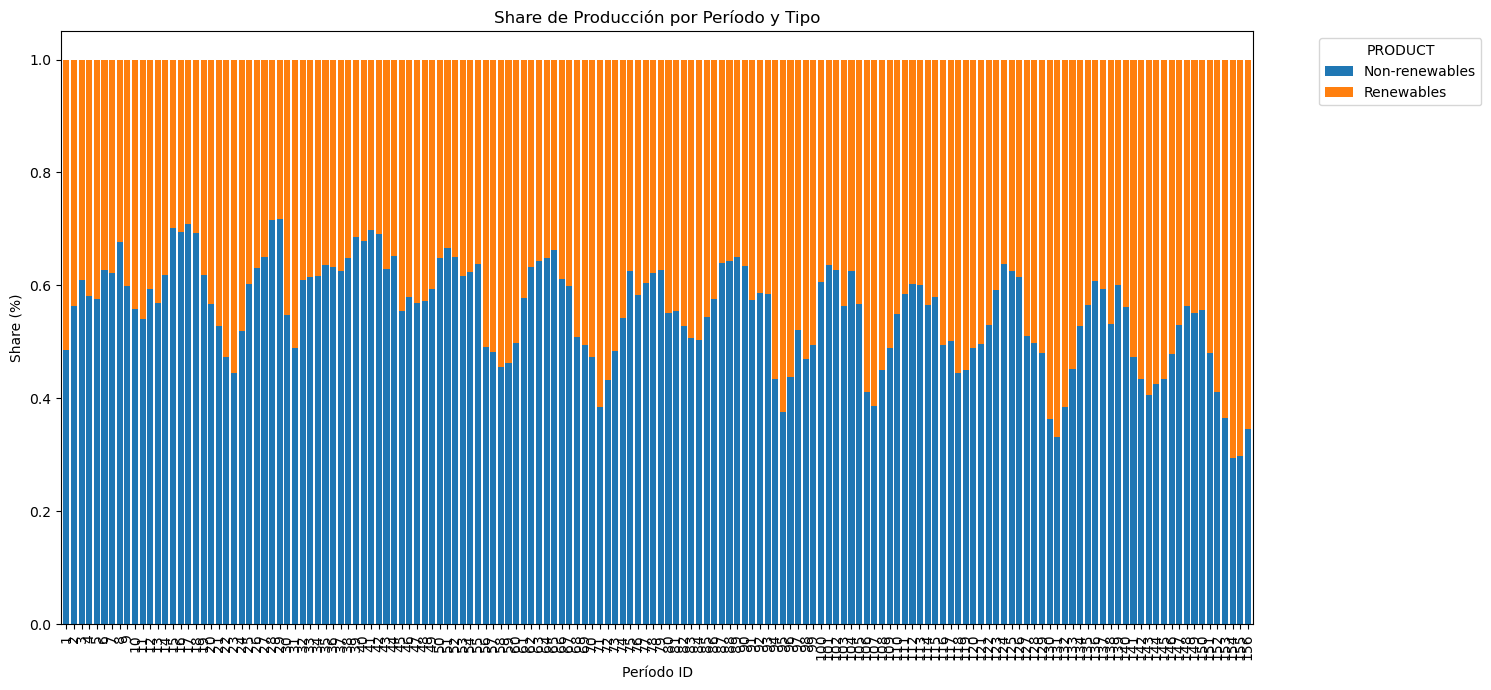

In [17]:

df_pivot = chile_products_id.pivot(
    index='periodo_id', 
    columns='PRODUCT', 
    values='share'
)

df_pivot.plot(
    kind='bar', 
    stacked=True, 
    figsize=(15, 7), 
    width=0.8      
)
plt.title('Share de Producción por Período y Tipo')
plt.xlabel('Período ID')
plt.ylabel('Share (%)')

plt.legend(title='PRODUCT', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() 
plt.show()

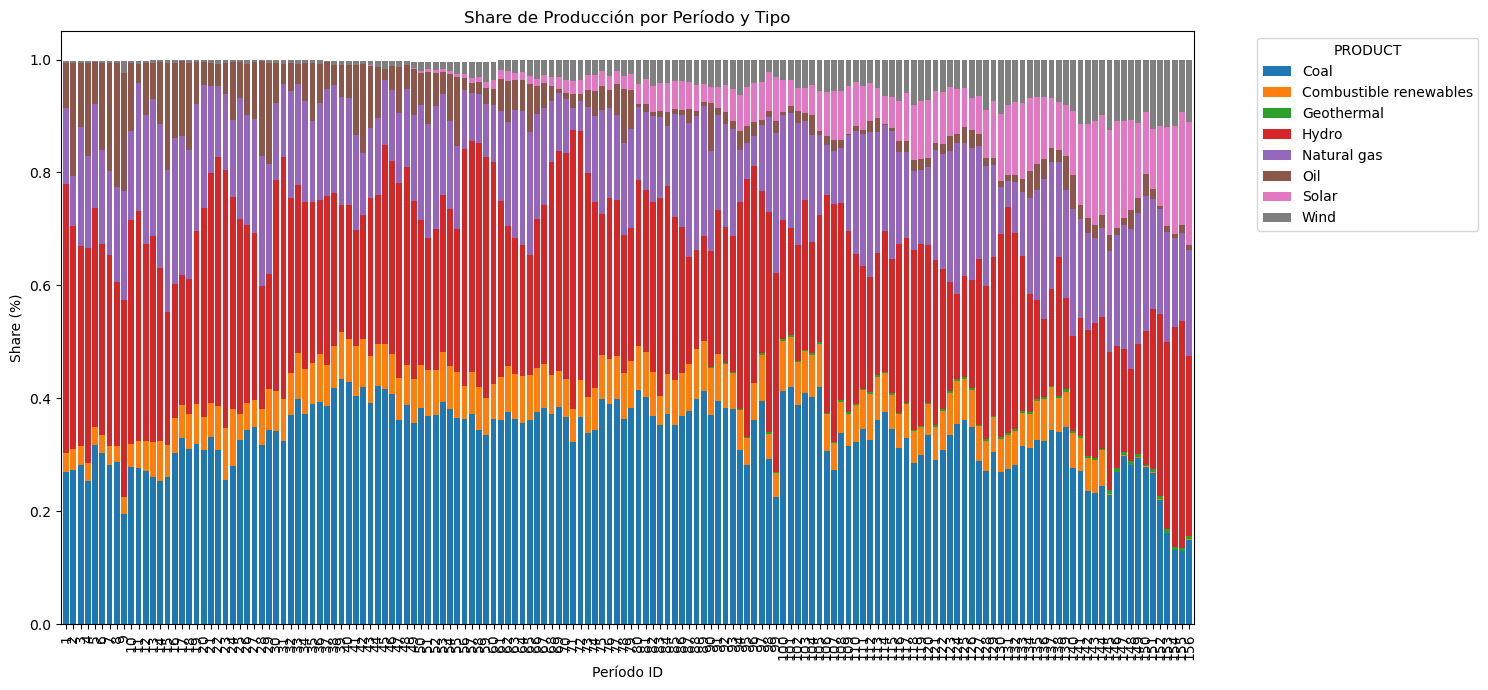

In [18]:
df_pivot_2 = chile_detailed_id.pivot(
    index='periodo_id', 
    columns='PRODUCT', 
    values='share'
)

df_pivot_2.plot(
    kind='bar', 
    stacked=True, 
    figsize=(15, 7), 
    width=0.8      
)
plt.title('Share de Producción por Período y Tipo')
plt.xlabel('Período ID')
plt.ylabel('Share (%)')

plt.legend(title='PRODUCT', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout() 
plt.show()

In [19]:
df_wide_detailed = chile_detailed_id.pivot(
    index='periodo_id', 
    columns='PRODUCT', 
    values='VALUE'
)

df_corr_detailed = df_wide_detailed.corr()

df_wide_grouped = chile_products_id.pivot(
    index='periodo_id', 
    columns='PRODUCT', 
    values='VALUE'
)
df_corr_grouped = df_wide_grouped.corr()



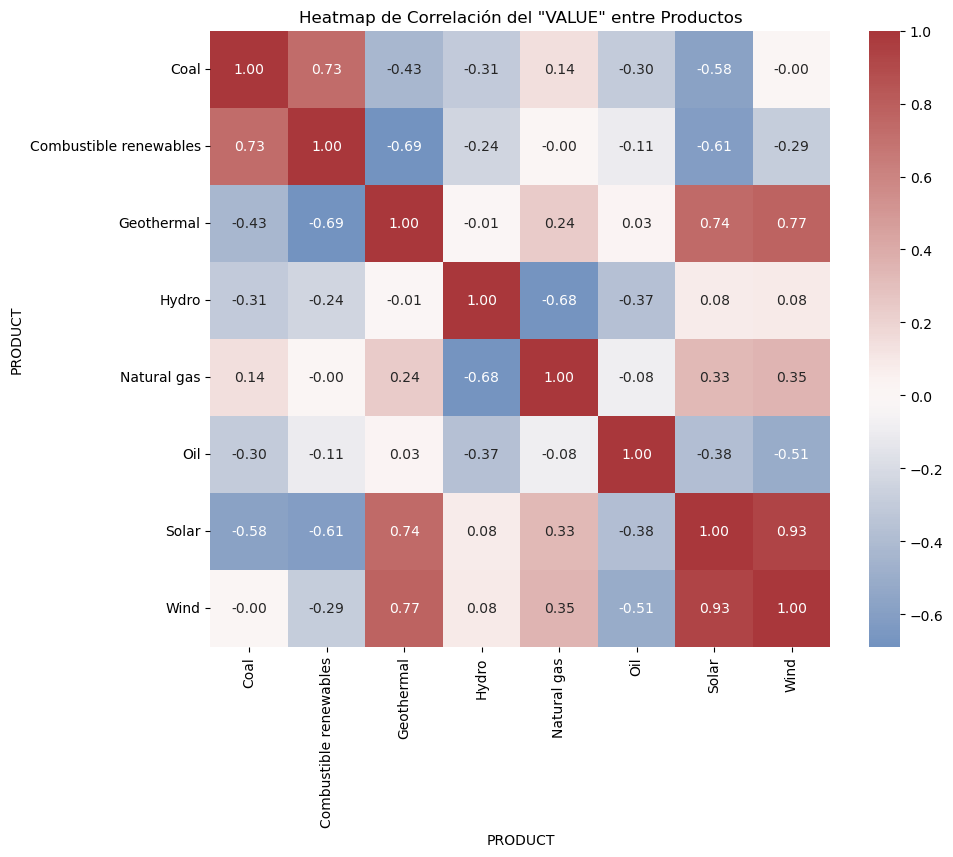

In [20]:
plt.figure(figsize=(10, 8))
sns.heatmap(
    df_corr_detailed, 
    annot=True,      # Muestra los valores numéricos en cada celda
    fmt='.2f',       # Formatea los números a 2 decimales
    cmap='vlag',     # Un buen mapa de color divergente (rojo-blanco-azul)
    center=0         # Centra la escala de color en 0 (perfecto para correlación)
)
plt.title('Heatmap de Correlación del "VALUE" entre Productos')
plt.show()

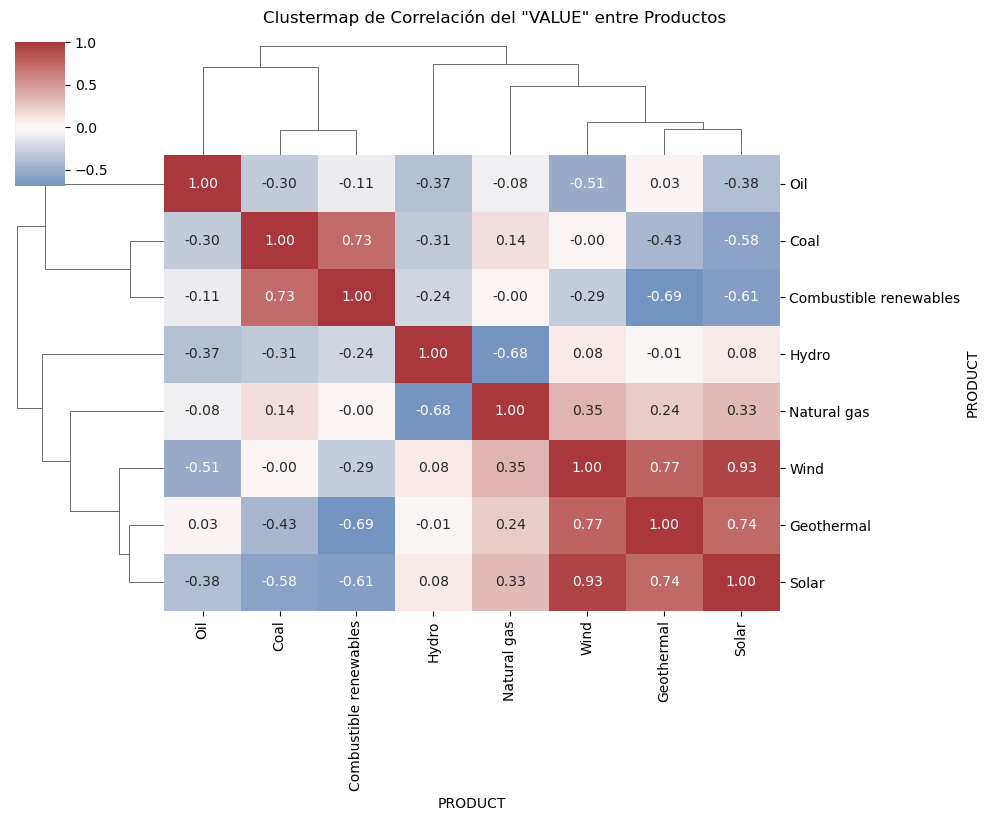

In [21]:
g = sns.clustermap(
    df_corr_detailed,
    annot=True,      # Muestra los valores numéricos
    fmt='.2f',       # Formato de 2 decimales
    cmap='vlag',     # Mapa de color divergente
    center=0,        # Centro en 0
    figsize=(10, 8)  # Tamaño de la figura
)

# Ajustar el título (se hace sobre la figura completa porque clustermap crea múltiples ejes)
g.fig.suptitle('Clustermap de Correlación del "VALUE" entre Productos', y=1.02)

plt.show()

In [22]:
df_matrix = chile_detailed_id.pivot_table(index='periodo_id', columns='PRODUCT', values='VALUE').fillna(0)

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df_matrix), index=df_matrix.index, columns=df_matrix.columns)

print("Datos preparados para ML/DL:", df_scaled.shape)
print(df_scaled.head())

Datos preparados para ML/DL: (156, 8)
PRODUCT         Coal  Combustible renewables  Geothermal     Hydro  \
periodo_id                                                           
1           0.194206                0.242485         0.0  0.667497   
2           0.152578                0.247234         0.0  0.393837   
3           0.182960                0.228414         0.0  0.312084   
4           0.130481                0.234684         0.0  0.393405   
5           0.296739                0.228974         0.0  0.443983   

PRODUCT     Natural gas       Oil  Solar      Wind  
periodo_id                                          
1              0.265622  0.328013    0.0  0.007046  
2              0.099458  0.778018    0.0  0.000200  
3              0.457797  0.440069    0.0  0.000000  
4              0.329547  0.656139    0.0  0.006173  
5              0.407068  0.298383    0.0  0.000179  


c:\Users\Admin\anaconda3\envs\data-science\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\data-science\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\data-science\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Admin\anaconda3\envs\data-science\Lib\site-packages\sklearn\cluster\_kmea

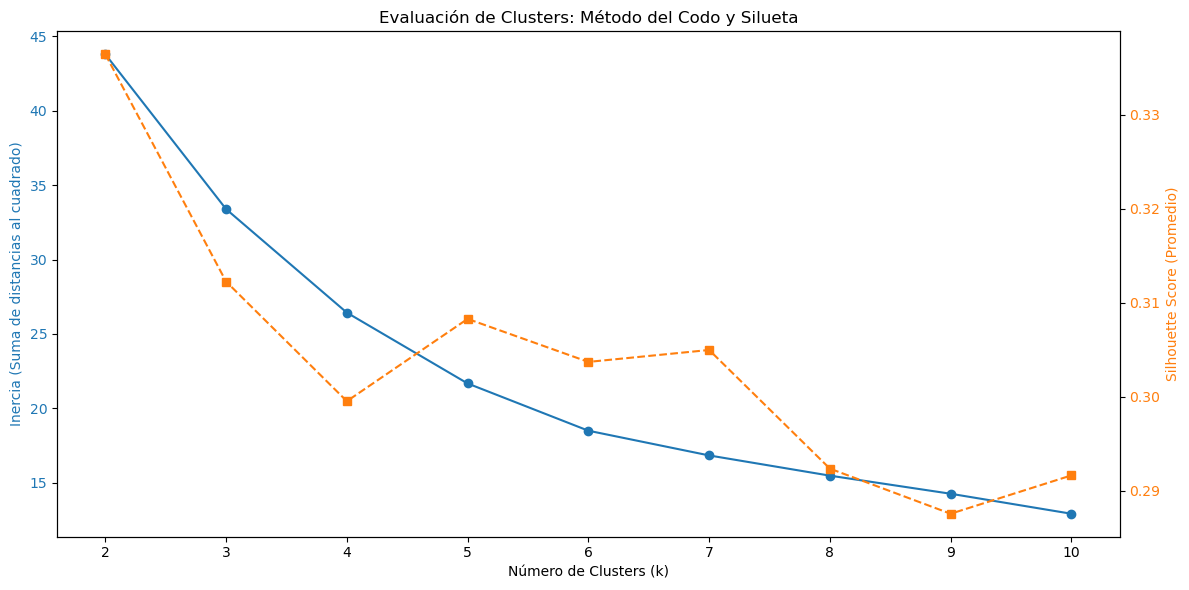

In [23]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Rango de clusters a probar (ej. de 2 a 10)
k_range = range(2, 11)
inertia_values = []
silhouette_values = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(df_scaled)
    
    # Guardar métricas
    inertia_values.append(kmeans.inertia_) # Para método del codo
    silhouette_values.append(silhouette_score(df_scaled, labels)) # Para silueta

# Crear gráfico de doble eje
fig, ax1 = plt.subplots(figsize=(12, 6))

# Eje Y izquierdo: Inercia (Codo)
color = 'tab:blue'
ax1.set_xlabel('Número de Clusters (k)')
ax1.set_ylabel('Inercia (Suma de distancias al cuadrado)', color=color)
ax1.plot(k_range, inertia_values, marker='o', color=color, label='Inercia (Codo)')
ax1.tick_params(axis='y', labelcolor=color)

# Eje Y derecho: Silueta
ax2 = ax1.twinx()  
color = 'tab:orange'
ax2.set_ylabel('Silhouette Score (Promedio)', color=color)
ax2.plot(k_range, silhouette_values, marker='s', linestyle='--', color=color, label='Silhouette Score')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Evaluación de Clusters: Método del Codo y Silueta')
plt.grid(True, axis='x')
fig.tight_layout() 
plt.show()

c:\Users\Admin\anaconda3\envs\data-science\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


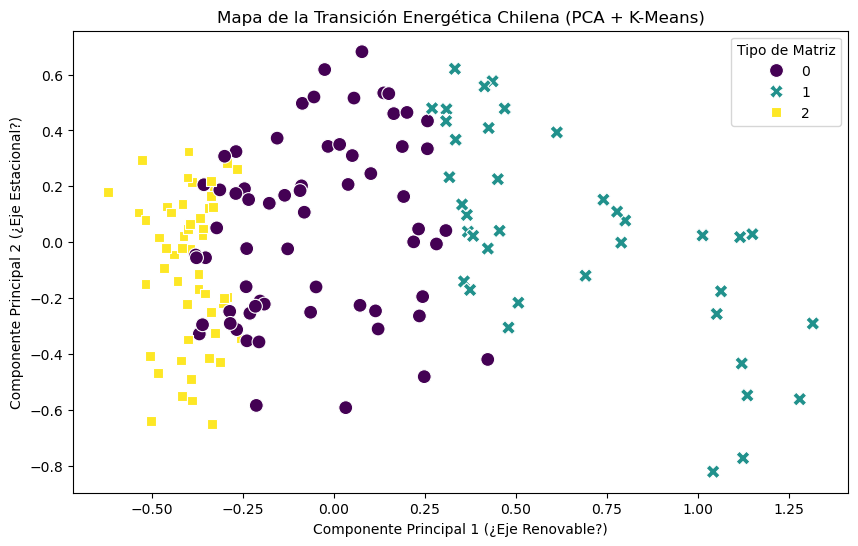

In [24]:
# 1. Clustering (K-Means)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(df_scaled)

# 2. Reducción de Dimensionalidad (PCA) para visualizar
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_scaled)

# Visualización
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x=pca_result[:, 0], 
    y=pca_result[:, 1], 
    hue=clusters, 
    palette='viridis', 
    s=100,
    style=clusters
)
plt.title('Mapa de la Transición Energética Chilena (PCA + K-Means)')
plt.xlabel('Componente Principal 1 (¿Eje Renovable?)')
plt.ylabel('Componente Principal 2 (¿Eje Estacional?)')
plt.legend(title='Tipo de Matriz')
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
Se detectaron 8 meses anómalos en la matriz.


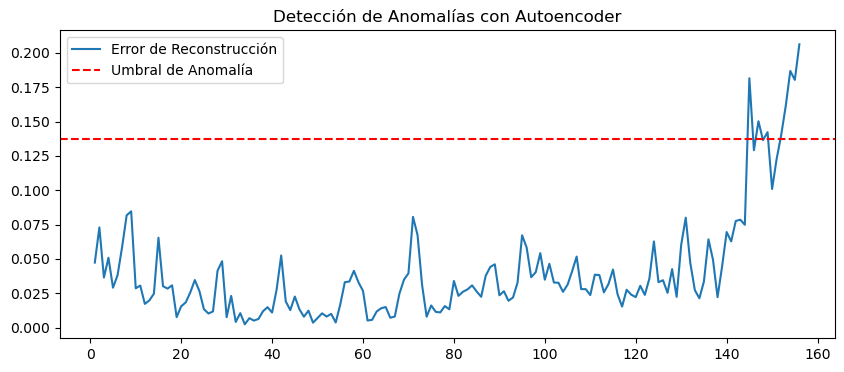

In [25]:
input_dim = df_scaled.shape[1] # Número de tipos de energía (columnas)
encoding_dim = 4 # Comprimimos la info a 4 neuronas (Embeddings)

# Encoder
input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded) # Latent Space

# Decoder
decoded = Dense(8, activation='relu')(encoded)
decoded = Dense(input_dim, activation='sigmoid')(decoded)

# Modelo completo
autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mse')

# Entrenar (Usamos los mismos datos para entrada y salida)
history = autoencoder.fit(
    df_scaled, df_scaled,
    epochs=50,
    batch_size=16,
    shuffle=True,
    verbose=0,
    validation_split=0.2
)

# Calcular error de reconstrucción para detectar anomalías
reconstructions = autoencoder.predict(df_scaled)
mse = np.mean(np.power(df_scaled - reconstructions, 2), axis=1)

# Definir umbral de anomalía (ej. percentil 95)
threshold = np.percentile(mse, 95)
anomalies = mse > threshold

print(f"Se detectaron {np.sum(anomalies)} meses anómalos en la matriz.")

# Visualizar el error de reconstrucción
plt.figure(figsize=(10, 4))
plt.plot(mse, label='Error de Reconstrucción')
plt.axhline(threshold, color='r', linestyle='--', label='Umbral de Anomalía')
plt.title('Detección de Anomalías con Autoencoder')
plt.legend()
plt.show()

In [ ]:

target_col = 'Solar'
data = df_matrix[target_col].values
X, y = [], []
look_back = 12 # Usar 12 meses pasados para predecir el siguiente

for i in range(len(data) - look_back):
    X.append(data[i:(i + look_back)])
    y.append(data[i + look_back])

X, y = np.array(X), np.array(y)

# Split Train/Test
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# --- Modelo 1: Random Forest ---
rf = RandomForestRegressor(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# --- Modelo 2: LSTM (Deep Learning) ---
# Reshape para LSTM [samples, time steps, features]
X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))



model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train_lstm, y_train, epochs=50, verbose=0)

y_pred_lstm = model_lstm.predict(X_test_lstm)
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred_lstm))

print(f"Resultados Supervisados (Solar):")
print(f"Random Forest RMSE: {rmse_rf:.2f}")
print(f"LSTM (DL) RMSE: {rmse_lstm:.2f}")

c:\Users\Admin\anaconda3\envs\data-science\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
Resultados Supervisados (Solar):
Random Forest RMSE: 430.69
LSTM (DL) RMSE: 162.42


In [27]:

def calculate_advanced_metrics(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)  
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100
    
    print(f"\n--- Evaluación Detallada: {model_name} ---")
    print(f"MAE (Error Promedio Absoluto): {mae:.2f} GWh")
    print(f"R² (Varianza Explicada): {r2:.4f}")
    print(f"MAPE (Error Promedio Porcentual): {mape:.2f} %")

calculate_advanced_metrics(y_test, y_pred_rf, "Random Forest")
calculate_advanced_metrics(y_test, y_pred_lstm, "LSTM (Deep Learning)")


--- Evaluación Detallada: Random Forest ---
MAE (Error Promedio Absoluto): 349.58 GWh
R² (Varianza Explicada): -1.4503
MAPE (Error Promedio Porcentual): 31.19 %

--- Evaluación Detallada: LSTM (Deep Learning) ---
MAE (Error Promedio Absoluto): 135.62 GWh
R² (Varianza Explicada): 0.6515
MAPE (Error Promedio Porcentual): 13.64 %


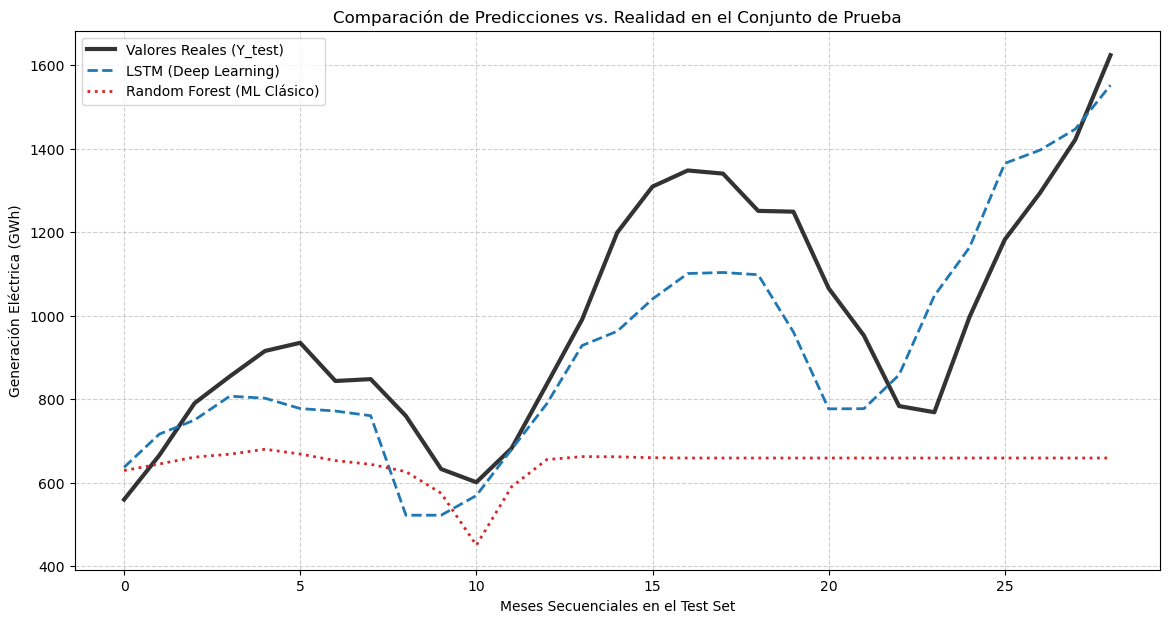

In [28]:

time_index_test = np.arange(len(y_test))

plt.figure(figsize=(14, 7))


plt.plot(time_index_test, y_test, 
         label='Valores Reales (Y_test)', 
         color='black', linewidth=3, alpha=0.8)


plt.plot(time_index_test, y_pred_lstm, 
         label='LSTM (Deep Learning)', 
         linestyle='--', color='tab:blue', linewidth=2)


plt.plot(time_index_test, y_pred_rf, 
         label='Random Forest (ML Clásico)', 
         linestyle=':', color='tab:red', linewidth=2)


plt.title('Comparación de Predicciones vs. Realidad en el Conjunto de Prueba')
plt.xlabel('Meses Secuenciales en el Test Set')
plt.ylabel('Generación Eléctrica (GWh)')
plt.legend(loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()